### adaptive threshold

In [1]:
from pathlib import Path
from datetime import datetime
import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2
import PIL.Image as Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Hyperparameter Setting

In [2]:
CFG = {
    'MODEL_NAME':'efb.',
    'DATA_PATH':Path(r'F:\datasets\dacon\hansol'),
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-3,
    'BATCH_SIZE':16,
    'SEED':41
}
train_path =CFG['DATA_PATH'] / 'train'
test_path = CFG['DATA_PATH'] / 'test'

## Fixed RandomSeed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [4]:
def rename_folder():
    """
    한글 폴더 명 0~n_classes 변경
    """
    folder_dict ={id:label for id,label in enumerate(os.listdir(train_path))}
    os.chdir(train_path)
    for old_folder_name in os.listdir(train_path):
        if old_folder_name in folder_dict.values():
            new_folder_name = str(list(folder_dict.keys())[list(folder_dict.values()).index(old_folder_name)])
            # print(old_folder_name,new_folder_name)
            os.rename(old_folder_name, new_folder_name)
folder_dict = {0: '가구수정',
               1: '걸레받이수정',
               2: '곰팡이',
               3: '꼬임',
               4: '녹오염',
               5: '들뜸',
               6: '면불량',
               7: '몰딩수정',
               8: '반점',
               9: '석고수정',
               10: '오염',
               11: '오타공',
               12: '울음',
               13: '이음부불량',
               14: '창틀,문틀수정',
               15: '터짐',
               16: '틈새과다',
               17: '피스',
               18: '훼손'}

## Data Pre-processing

In [5]:
# './train/*/*'
all_img_list = glob.glob(str(CFG['DATA_PATH'] / 'train/*/*'))
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('\\')[-2])
train_df, val, _, _ = train_test_split(df, df['label'], test_size=0.1, stratify=df['label'], random_state=CFG['SEED'])

## CustomDataset

In [6]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [7]:
from dev.devlib import TDataset, transform_adaptive_th

train_dataset = TDataset(train_df['img_path'].values, train_df['label'].values, transform_adaptive_th)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = TDataset(val['img_path'].values, val['label'].values, transform_adaptive_th)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

100%|██████████| 1038/1038 [00:09<00:00, 108.35it/s]


### model define

In [8]:
class ConvNeXt(nn.Module):
    def __init__(self, num_classes=19):
        super(ConvNeXt, self).__init__()
        self.model = models.convnext_base(weights=models.convnext.ConvNeXt_Base_Weights.IMAGENET1K_V1)
        # self.model = models.efficientnet_b0(weights=models.efficientnet.EfficientNet_B0_Weights.IMAGENET1K_V1)
        self.model.classifier[2] = nn.Linear(in_features=self.model.classifier[2].in_features, out_features=num_classes)
        # input dim == 0
        self.model.features[0][0] = nn.Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
        
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.classifier.parameters():
            param.requires_grad = True

        self.model.features[0][0].requires_grad_(True)

    def forward(self,x):
        x = self.model(x)
        return x
        
class simpleUnet(nn.modules):
    def __init__(self,in_ch,out_ch):
        super().__init__()

        self.conv0 = nn.Conv2d(in_ch,32,3,1,padding=1,bias=False)

        

    def forward(self,x):


        return x

## Train

In [9]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(train_loader):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model

In [10]:
def validation(model, criterion, val_loader, device,return_lists=False):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    if return_lists:
        return true_labels, preds
    else:
        return _val_loss, _val_score

## Run!!

In [11]:
BaseModel = ConvNeXt
model = BaseModel()
model.eval()
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.98779] Val Loss : [1.75859] Val Weighted F1 Score : [0.36929]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [2], Train Loss : [1.77587] Val Loss : [1.61699] Val Weighted F1 Score : [0.43818]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [3], Train Loss : [1.64632] Val Loss : [1.47047] Val Weighted F1 Score : [0.51510]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [4], Train Loss : [1.46050] Val Loss : [1.18528] Val Weighted F1 Score : [0.58957]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [5], Train Loss : [1.25420] Val Loss : [1.10254] Val Weighted F1 Score : [0.60729]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [6], Train Loss : [1.12031] Val Loss : [1.05333] Val Weighted F1 Score : [0.64670]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [7], Train Loss : [1.05401] Val Loss : [1.06186] Val Weighted F1 Score : [0.64327]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.95827] Val Loss : [0.95538] Val Weighted F1 Score : [0.66467]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.90824] Val Loss : [0.92941] Val Weighted F1 Score : [0.67509]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.86393] Val Loss : [1.00670] Val Weighted F1 Score : [0.65455]


In [12]:
infer_model = train(infer_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.82433] Val Loss : [0.93398] Val Weighted F1 Score : [0.68446]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.80035] Val Loss : [0.89437] Val Weighted F1 Score : [0.68116]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.76132] Val Loss : [0.90307] Val Weighted F1 Score : [0.69165]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.74239] Val Loss : [0.95151] Val Weighted F1 Score : [0.68037]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.69623] Val Loss : [0.91853] Val Weighted F1 Score : [0.69283]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.70682] Val Loss : [0.94579] Val Weighted F1 Score : [0.68146]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.65949] Val Loss : [0.93913] Val Weighted F1 Score : [0.69108]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.66578] Val Loss : [0.95458] Val Weighted F1 Score : [0.68801]
Epoch 00018: reducing learning rate of group 0 to 1.5000e-03.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.58718] Val Loss : [0.89371] Val Weighted F1 Score : [0.69899]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.56390] Val Loss : [0.90628] Val Weighted F1 Score : [0.70918]


In [13]:
infer_model = train(infer_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.55013] Val Loss : [0.94330] Val Weighted F1 Score : [0.70580]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.55087] Val Loss : [0.86915] Val Weighted F1 Score : [0.71463]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.52981] Val Loss : [0.90138] Val Weighted F1 Score : [0.71323]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.52855] Val Loss : [0.87544] Val Weighted F1 Score : [0.71777]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.53637] Val Loss : [0.90568] Val Weighted F1 Score : [0.70097]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.54986] Val Loss : [0.89111] Val Weighted F1 Score : [0.70688]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.53849] Val Loss : [0.93957] Val Weighted F1 Score : [0.70367]
Epoch 00027: reducing learning rate of group 0 to 7.5000e-04.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.49617] Val Loss : [0.89096] Val Weighted F1 Score : [0.71258]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.47520] Val Loss : [0.89443] Val Weighted F1 Score : [0.71892]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.46344] Val Loss : [0.90285] Val Weighted F1 Score : [0.71315]


In [14]:
infer_model = train(infer_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.46267] Val Loss : [0.89481] Val Weighted F1 Score : [0.71447]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.45663] Val Loss : [0.88759] Val Weighted F1 Score : [0.71731]
Epoch 00032: reducing learning rate of group 0 to 3.7500e-04.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.43613] Val Loss : [0.89377] Val Weighted F1 Score : [0.70542]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.44327] Val Loss : [0.89910] Val Weighted F1 Score : [0.70870]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.43577] Val Loss : [0.88754] Val Weighted F1 Score : [0.70470]
Epoch 00035: reducing learning rate of group 0 to 1.8750e-04.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.42707] Val Loss : [0.88503] Val Weighted F1 Score : [0.71934]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.41833] Val Loss : [0.89578] Val Weighted F1 Score : [0.70803]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.42244] Val Loss : [0.89228] Val Weighted F1 Score : [0.71189]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.43405] Val Loss : [0.89913] Val Weighted F1 Score : [0.70857]
Epoch 00039: reducing learning rate of group 0 to 9.3750e-05.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.41097] Val Loss : [0.89512] Val Weighted F1 Score : [0.71188]


In [15]:
infer_model = train(infer_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.40679] Val Loss : [0.89639] Val Weighted F1 Score : [0.71134]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.43663] Val Loss : [0.89558] Val Weighted F1 Score : [0.71513]
Epoch 00042: reducing learning rate of group 0 to 4.6875e-05.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.40782] Val Loss : [0.89553] Val Weighted F1 Score : [0.71523]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.43118] Val Loss : [0.89616] Val Weighted F1 Score : [0.71550]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.39862] Val Loss : [0.89468] Val Weighted F1 Score : [0.71611]
Epoch 00045: reducing learning rate of group 0 to 2.3438e-05.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.41276] Val Loss : [0.89468] Val Weighted F1 Score : [0.71712]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.39942] Val Loss : [0.89504] Val Weighted F1 Score : [0.71565]


  0%|          | 0/152 [00:00<?, ?it/s]

In [ ]:
infer_model = train(infer_model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.37704] Val Loss : [0.85988] Val Weighted F1 Score : [0.70956]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.36913] Val Loss : [0.85992] Val Weighted F1 Score : [0.70956]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.37354] Val Loss : [0.85993] Val Weighted F1 Score : [0.70958]
Epoch 00053: reducing learning rate of group 0 to 7.3242e-07.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.36761] Val Loss : [0.85994] Val Weighted F1 Score : [0.70958]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.37060] Val Loss : [0.85998] Val Weighted F1 Score : [0.70958]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.37275] Val Loss : [0.86004] Val Weighted F1 Score : [0.70958]
Epoch 00056: reducing learning rate of group 0 to 3.6621e-07.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.38258] Val Loss : [0.86005] Val Weighted F1 Score : [0.70958]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.36049] Val Loss : [0.86005] Val Weighted F1 Score : [0.70958]


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.37857] Val Loss : [0.86006] Val Weighted F1 Score : [0.70958]
Epoch 00059: reducing learning rate of group 0 to 1.8311e-07.


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.38316] Val Loss : [0.86007] Val Weighted F1 Score : [0.70958]


In [ ]:
true_labels, preds = validation(infer_model, nn.CrossEntropyLoss(),val_loader, device,True)

  0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
print(classification_report(true_labels,preds))

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.76      0.84      0.80        92
           2       0.52      0.60      0.56        43
           3       0.90      1.00      0.95        63
           4       0.50      0.25      0.33         4
           5       0.61      0.69      0.65        16
           6       0.35      0.20      0.26        30
           7       0.58      0.56      0.57        39
           8       0.00      0.00      0.00         1
           9       0.45      0.29      0.36        17
          10       0.63      0.56      0.59       179
          11       0.80      0.81      0.80        43
          12       0.50      0.57      0.53         7
          13       0.50      0.60      0.55         5
          14       0.60      0.38      0.46         8
          15       0.73      0.73      0.73        49
          16       0.00      0.00      0.00         1
          17       0.65    

## Inference

In [ ]:
test_dataset = TDataset([str(test_path / file) for file in os.listdir(test_path)], None, transform_adaptive_th)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

100%|██████████| 792/792 [00:14<00:00, 54.95it/s]


In [ ]:
def inverse_transform(preds):
    return np.array([folder_dict[pred] for pred in preds])

In [ ]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    preds = inverse_transform(preds)
    return preds

In [ ]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/50 [00:00<?, ?it/s]

## Submission

In [ ]:
submit = pd.read_csv(CFG['DATA_PATH'] / 'sample_submission.csv')
submit['label'] = preds

In [ ]:
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%H_%M")
os.makedirs('./result',exist_ok=True)
submit.to_csv(f'./result/{CFG["MODEL_NAME"]}_{formatted_datetime}.csv', index=False)

<AxesSubplot: >

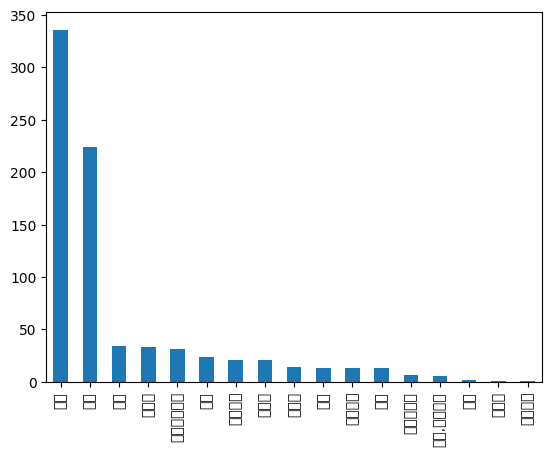

In [ ]:
submit['label'].value_counts().plot(kind='bar')

In [ ]:
# todo : convnext의 val값이 올라도 성능 저하 확인